In [28]:
from tqdm.auto import tqdm
from rl_analysis.plotting import setup_plotting_env, geno_palette
from rl_analysis.maya.process import (
    TARGETS,
    add_area,
    add_trial_count,
    add_onset_and_duration,
)
from rl_analysis.io.df import exclude_uuids
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [2]:
setup_plotting_env()

In [4]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [5]:
raw_dirs = analysis_config["raw_data"]
figure_cfg = analysis_config["figures"]

In [3]:
sim_files = os.path.join(
    raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet"
)

In [4]:
load_keys = [
    "mouse_id",
    "predicted_syllable",
    "predicted_syllable (offline)",
    "area (pooled)",
    "date",
    "uuid",
    "genotype",
    "target_syllable",
    "syllable_group",
    "timestamp",
    "session_number",
    "velocity_3d_mm",
    "feedback_status",
    "centroid_x_mm",
    "centroid_y_mm",
]

In [5]:
feedback_df = pd.read_parquet(sim_files, columns=load_keys)

In [6]:
feedback_df.keys()

Index(['mouse_id', 'predicted_syllable', 'predicted_syllable (offline)',
       'area (pooled)', 'date', 'uuid', 'genotype', 'target_syllable',
       'syllable_group', 'timestamp', 'session_number', 'velocity_3d_mm',
       'feedback_status', 'centroid_x_mm', 'centroid_y_mm'],
      dtype='object')

In [7]:
sim_files

'/home/markowitzmeister_gmail_com/jeff_win_share/reinforcement_data/_final_test/_data/_to_upload_zenodo/optoda_raw_data/closed_loop_behavior_transfer.parquet'

In [8]:
def recenter_grid(gb):  # need to translate/ flip image to center from kinect
    xc = (gb.centroid_x_mm.max() - gb.centroid_x_mm.min()) / 2
    yc = (gb.centroid_y_mm.max() + gb.centroid_y_mm.min()) / 2

    gb["centroid_x_mm"] = gb.centroid_x_mm + xc
    gb["centroid_y_mm"] = gb.centroid_y_mm - yc

    return gb

In [9]:
feedback_df = add_area(feedback_df)
feedback_df = feedback_df[~feedback_df.uuid.isin(exclude_uuids)]
feedback_df = add_onset_and_duration(feedback_df)

In [10]:
# Final submission mouse_ids
ctrls = [
    "10",
    "1527",
    "1561",
    "197",
    "200",
    "208",
    "209",
    "211",
    "snc-dls-ctrl-6",
    "snc-dls-ctrl-7",
    "vta-nacc-ctrl-6",
    "vta-nacc-ctrl-7",
]
sncs = [
    "1546",
    "1528",
    "1529",
    "1544",
    "15822",
    "15823",
    "15847",
    "410",
    "240",
    "242",
    "239",
    "241",
    "3441",
    "3440",
    "3442",
    "dls-ai32jr-1",
    "dls-ai32jr-3",
    "dls-ai32jr-5",
    "dls-ai32jr-2",
    "dls-ai32jr-4",
]

In [11]:
feedback_df = feedback_df[
    feedback_df.mouse_id.isin(ctrls) | feedback_df.mouse_id.isin(sncs)
]

In [12]:
sorted(feedback_df.mouse_id.unique()) == sorted(ctrls + sncs)

True

In [13]:
keys = ["centroid_x_mm", "centroid_y_mm"]

In [14]:
# Center the arena on origin
feedback_df = feedback_df.groupby("uuid").apply(recenter_grid)

/tmp/ipykernel_22302/3611979485.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  feedback_df = feedback_df.groupby('uuid').apply(recenter_grid)


# Now let's compute JSD for each mouse x target pair independently, then average across groups

In [16]:
from scipy.spatial.distance import jensenshannon

In [18]:
baseline_targets = feedback_df[
    feedback_df.session_number.isin([-1, 0, 3, 4])
    & feedback_df.predicted_syllable.isin(TARGETS)
    & (feedback_df.onset == 1)
]
stimday_targets = feedback_df[
    feedback_df.session_number.isin([1, 2])
    & feedback_df.predicted_syllable.isin(TARGETS)
    & (feedback_df.onset == 1)
]

In [22]:
TARGETS

(17, 20, 27, 30, 59, 76)

In [19]:
jsds = []

# for _a in feedback_df['area'].unique():
for _a in ["snc (axon)", "ctrl"]:

    area_df = feedback_df[feedback_df["area"] == _a]
    for _m in tqdm(area_df.mouse_id.unique()):
        for t in TARGETS:

            base_df = baseline_targets[
                (baseline_targets.mouse_id == _m)
                & (baseline_targets.predicted_syllable == t)
            ][keys]
            stim_df = stimday_targets[
                (stimday_targets.mouse_id == _m)
                & (stimday_targets.predicted_syllable == t)
            ][keys]

            heatmap, xedges, yedges = np.histogram2d(
                base_df.centroid_x_mm, base_df.centroid_y_mm, bins=10, density=False
            )
            heatmap2, xedges2, yedges2 = np.histogram2d(
                stim_df.centroid_x_mm, stim_df.centroid_y_mm, bins=10, density=False
            )

            # Normalized 1D probability distributions for each location heatmap (binned x,y coords)
            b_dist = (heatmap / heatmap.ravel().sum()).ravel()
            s_dist = (heatmap2 / heatmap2.ravel().sum()).ravel()

            dct = {
                "area": _a,
                "mouse_id": _m,
                "target": t,
                "jsd": jensenshannon(s_dist, b_dist),
            }

            jsds.append(dct)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [20]:
jsd_df = pd.DataFrame(jsds)

In [21]:
jsd_df[jsd_df.area == "snc (axon)"].mouse_id.unique()

array(['3440', '3441', '3442', '1528', '1529', '1544', '1546', '15822',
       '15823', '15847', '239', '240', '241', '242', '410',
       'dls-ai32jr-1', 'dls-ai32jr-2', 'dls-ai32jr-3', 'dls-ai32jr-4',
       'dls-ai32jr-5'], dtype=object)

Now what if we zscore the JSDs by syllable and group them together?

In [23]:
len(jsd_df)

192

In [24]:
jsd_df.mouse_id.nunique() * jsd_df.target.nunique()

192

In [25]:
from scipy.stats import zscore

In [26]:
jsd_df["z_jsd"] = jsd_df.groupby(["area", "target"])["jsd"].transform(zscore)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

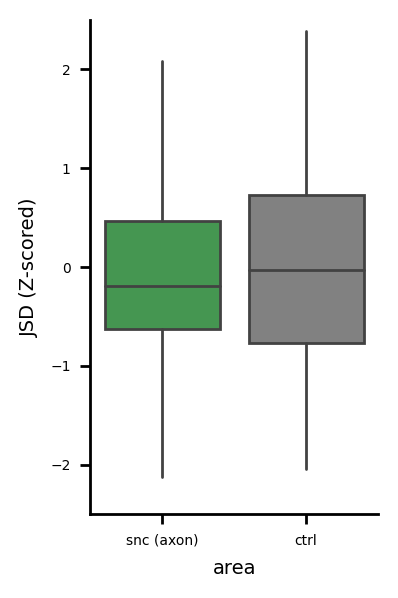

In [29]:
# Zscored JSD by syllable
fig, ax = plt.subplots(1, 1, figsize=(2, 3))
sns.boxplot(
    data=jsd_df,
    x="area",
    y="z_jsd",
    order=["snc (axon)", "ctrl"],
    palette=[geno_palette[0], geno_palette[2]],
    fliersize=3,
    showcaps=False,
    showfliers=False,
    ax=ax,
)

sns.despine()
ax.set_ylabel("JSD (Z-scored)")
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()

plt.show()

In [30]:
sorted(jsd_df.mouse_id.unique()) == sorted(ctrls + sncs)

True

In [31]:
from scipy.stats import ttest_ind, ranksums, mannwhitneyu

In [32]:
jsd_df

,area,mouse_id,target,jsd,z_jsd
0,snc (axon),3440,17,0.101107,-1.182796
1,snc (axon),3440,20,0.083642,-1.674696
2,snc (axon),3440,27,0.106223,0.083032
3,snc (axon),3440,30,0.202198,-0.528563
4,snc (axon),3440,59,0.099170,-2.117309
...,...,...,...,...,...
187,ctrl,vta-nacc-ctrl-7,20,0.227473,2.384620
188,ctrl,vta-nacc-ctrl-7,27,0.089414,-1.031313
189,ctrl,vta-nacc-ctrl-7,30,0.162616,-0.768830
190,ctrl,vta-nacc-ctrl-7,59,0.195086,-0.256093


# Now compute JSDs for all locations, not just during the target:

In [33]:
baseline_targets = feedback_df[
    feedback_df.session_number.isin([-1, 0, 3, 4])
    # & feedback_df.predicted_syllable.isin(TARGETS)
    & (feedback_df.onset == 1)
]
stimday_targets = feedback_df[
    feedback_df.session_number.isin([1, 2])
    # & feedback_df.predicted_syllable.isin(TARGETS)
    & (feedback_df.onset == 1)
]

In [34]:
jsds = []


for _a in ["snc (axon)", "ctrl"]:
    area_df = feedback_df[feedback_df["area"] == _a]
    for _m in tqdm(area_df.mouse_id.unique()):

        base_df = baseline_targets[(baseline_targets.mouse_id == _m)][keys]
        stim_df = stimday_targets[(stimday_targets.mouse_id == _m)][keys]

        heatmap, xedges, yedges = np.histogram2d(
            base_df.centroid_x_mm, base_df.centroid_y_mm, bins=10, density=False
        )
        heatmap2, xedges2, yedges2 = np.histogram2d(
            stim_df.centroid_x_mm, stim_df.centroid_y_mm, bins=10, density=False
        )

        # Normalized 1D probability distributions for each location heatmap (binned x,y coords)
        b_dist = (heatmap / heatmap.ravel().sum()).ravel()
        s_dist = (heatmap2 / heatmap2.ravel().sum()).ravel()

        dct = {
            "area": _a,
            "mouse_id": _m,
            "jsd": jensenshannon(s_dist, b_dist),
        }

        jsds.append(dct)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [35]:
jsd_df = pd.DataFrame(jsds)

jsd_df["z_jsd"] = jsd_df.groupby(["area"])["jsd"].transform(zscore)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

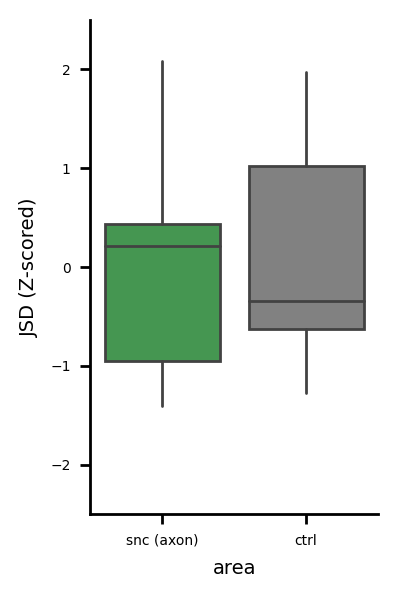

In [36]:
# Zscored JSD by syllable
fig, ax = plt.subplots(1, 1, figsize=(2, 3))
sns.boxplot(
    data=jsd_df,
    x="area",
    y="z_jsd",
    order=["snc (axon)", "ctrl"],
    palette=[geno_palette[0], geno_palette[2]],
    fliersize=3,
    showcaps=False,
    showfliers=False,
    ax=ax,
)

sns.despine()
ax.set_ylabel("JSD (Z-scored)")
ax.set_ylim(-2.5, 2.5)
plt.tight_layout()

plt.show()

## Mouse x target heatmaps

In [37]:
maps = []

for _a in ["snc (axon)", "ctrl"]:
    area_df = feedback_df[feedback_df["area"] == _a]
    for _m in tqdm(area_df.mouse_id.unique()):
        for t in TARGETS:

            base_df = baseline_targets[
                (baseline_targets.mouse_id == _m)
                & (baseline_targets.predicted_syllable == t)
            ][keys]
            stim_df = stimday_targets[
                (stimday_targets.mouse_id == _m)
                & (stimday_targets.predicted_syllable == t)
            ][keys]

            heatmap, xedges, yedges = np.histogram2d(
                base_df.centroid_x_mm, base_df.centroid_y_mm, bins=50, density=False
            )
            heatmap2, xedges2, yedges2 = np.histogram2d(
                stim_df.centroid_x_mm, stim_df.centroid_y_mm, bins=50, density=False
            )

            norm = heatmap / heatmap.sum()
            norm2 = heatmap2 / heatmap2.sum()

            diff = norm2 - norm

            dct = {
                "area": _a,
                "mouse_id": _m,
                "target": t,
                "stim": norm2,
                "baseline": norm,
                "diff": diff,
            }

            maps.append(dct)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [38]:
map_df = pd.DataFrame(maps)

In [39]:
map_df = map_df.melt(id_vars=["area", "mouse_id", "target"])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

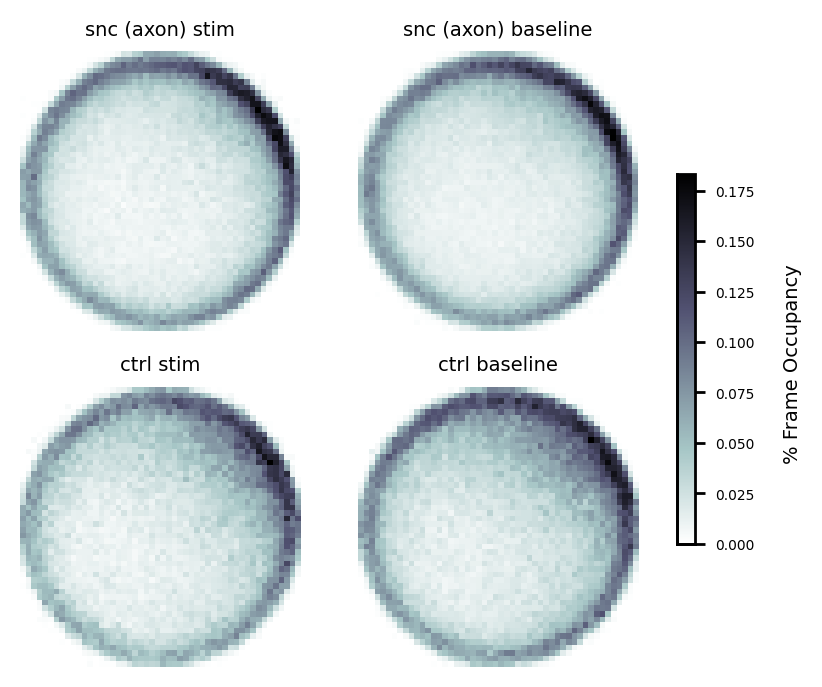

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(5, 4))
i = 0


for _a in ["snc (axon)", "ctrl"]:
    for day in ["stim", "baseline"]:
        _ax = ax.ravel()[i]
        _df = map_df[(map_df.area == _a) & (map_df.variable == day)]
        p = _ax.imshow(
            _df["value"].mean() * 100,
            cmap="bone_r",
        )
        _ax.axis("off")
        _ax.set_title(_a + " " + day)
        i += 1

fig.colorbar(
    p,
    ax=ax.ravel().tolist(),
    shrink=0.6,
)
fig.text(0.89, 0.37, "% Frame Occupancy", rotation=90)
# plt.tight_layout()
sns.despine()